In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import numpy.random as nr
import math
from sklearn import preprocessing
import sklearn.model_selection as ms
from sklearn import linear_model
import sklearn.metrics as sklm

%matplotlib inline

In [5]:
## Load dataset

credit = pd.read_csv('German_Credit_Preped.csv')
print(credit.dtypes)
# print(credit.head())

# Examine the class imbalance in the data
credit_counts = credit[['credit_history', 'bad_credit']].groupby('bad_credit').count()
# print(credit['bad_credit'].unique())
credit_counts

customer_id                  int64
checking_account_status     object
loan_duration_mo             int64
credit_history              object
purpose                     object
loan_amount                  int64
savings_account_balance     object
time_employed_yrs           object
payment_pcnt_income          int64
gender_status               object
other_signators             object
time_in_residence            int64
property                    object
age_yrs                      int64
other_credit_outstanding    object
home_ownership              object
number_loans                 int64
job_category                object
dependents                   int64
telephone                   object
foreign_worker              object
bad_credit                   int64
dtype: object


credit_history
bad_credit                
0                      700
1                      300

In [6]:
## Prepare data for scikit-learn model

labels = np.array(credit['bad_credit'])

# Deal with categorical variables
def encoding_string(cat_features):
    # Encode the strings to numeric values
    enc = preprocessing.LabelEncoder()
    enc.fit(cat_features)
    enc_cat_features = enc.transform(cat_features)
    # One hot encoding
    ohe = preprocessing.OneHotEncoder()
    encoded = ohe.fit(enc_cat_features.reshape(-1,1))
    encoded = encoded.transform(enc_cat_features.reshape(-1, 1)).toarray()  # Convert the one hot encoder to array
    return encoded

Features = encoding_string(credit['checking_account_status'])
categorical_columns = ['credit_history', 'purpose', 'gender_status', 'time_in_residence', 'property']
for col in categorical_columns:
    temp = encoding_string(credit[col])
    Features = np.concatenate([Features, temp], axis = 1)

# print(Features.shape)
# print(Features[:2, :])

# Add numeric features at the end
Features = np.concatenate([Features, np.array(credit[['loan_duration_mo', 'loan_amount', 
                            'payment_pcnt_income', 'age_yrs']])], axis = 1)

# Split the data set to train set and test set
nr.seed(9988)
indx = range(Features.shape[0])
indx = ms.train_test_split(indx, test_size = 300)
X_train = Features[indx[0], :]
y_train = np.ravel(labels[indx[0]])
X_test = Features[indx[1], :]
y_test = np.ravel(labels[indx[1]])

# Sacle numeric variable using train set
scaler = preprocessing.StandardScaler().fit(X_train[:, 34:])
X_train[:, 34:] = scaler.transform(X_train[:, 34:])
X_test[:, 34:] = scaler.transform(X_test[:, 34:])
X_train.shape

(700, 35)

In [7]:
## Construct logistic regression model

logistic_mod = linear_model.LogisticRegression()
logistic_mod.fit(X_train, y_train)

# print(logistic_mod.intercept_, logistic_mod.coef_)
probabilities = logistic_mod.predict_proba(X_test)
# The first column is the probability of a score of 0 and the second column is the probability of score of 1
print(probabilities[:15,:])

[[0.88786998 0.11213002]
 [0.39059283 0.60940717]
 [0.96342378 0.03657622]
 [0.28662383 0.71337617]
 [0.63179081 0.36820919]
 [0.95329508 0.04670492]
 [0.91618594 0.08381406]
 [0.54191103 0.45808897]
 [0.91401019 0.08598981]
 [0.90697355 0.09302645]
 [0.51764213 0.48235787]
 [0.44176329 0.55823671]
 [0.47187531 0.52812469]
 [0.77148045 0.22851955]
 [0.31550272 0.68449728]]


/Users/futongli/opt/anaconda3/envs/notebook/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[0 1 0 1 0 0 0 0 0 0 0 1 0 0 1]
[0 0 0 1 0 0 0 0 1 0 0 1 1 0 1]
                 Confusion matrix
                 Score positive    Score negative
Actual positive       180                32
Actual negative        40                48

Accuracy  0.76
 
           Positive      Negative
Num case      212            88
Precision    0.82          0.60
Recall       0.85          0.55
F1           0.83          0.57


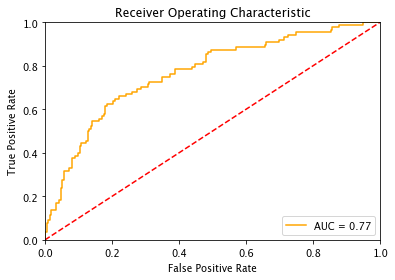

'\nThe confusion matrix shows the following characteristics; \n    a) most of the positive cases are correctly classified, 182 vs. 30, however, \n    b) may negative cases are are scored incorrectly, with only 49 correct, vs. 39 incorrect\nThe overall accuracy is 0.77. However as just observed this is extremely misleading!\nThe class imbalance is confirmed. Of the 300 test cases 212 are positive and 88 are negative.\nThe precision, recall and F1 all show that positive cases are classified reasonably well, \n    but the negative cases are not.\n'

In [37]:
## Score and evaluate the classification model

def score_model(probs, threshold):
    # compute the positive ( 1 ) predictions
    return np.array([1 if x > threshold else 0 for x in probs[:, 1]])

scores = score_model(probabilities, 0.5)
print(np.array(scores[:15]))
print(y_test[:15])

def print_metrics(labels, scores):
    metrics = sklm.precision_recall_fscore_support(labels, scores)
    conf = sklm.confusion_matrix(labels, scores)
    print('                 Confusion matrix')
    print('                 Score positive    Score negative')
    print('Actual positive    %6d' % conf[0,0] + '             %5d' % conf[0,1])
    print('Actual negative    %6d' % conf[1,0] + '             %5d' % conf[1,1])
    print('')
    print('Accuracy  %0.2f' % sklm.accuracy_score(labels, scores))
    print(' ')
    print('           Positive      Negative')
    print('Num case   %6d' % metrics[3][0] + '        %6d' % metrics[3][1])
    print('Precision  %6.2f' % metrics[0][0] + '        %6.2f' % metrics[0][1])
    print('Recall     %6.2f' % metrics[1][0] + '        %6.2f' % metrics[1][1])
    print('F1         %6.2f' % metrics[2][0] + '        %6.2f' % metrics[2][1]) 

def plot_auc(labels, probs):
    # Compute the false positive rate, true positive rate and threshold along with the AUC
    fpr, tpr, threshold = sklm.roc_curve(labels, probs[:,1])
    auc = sklm.auc(fpr, tpr)
    
    # Plot the result
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, color = 'orange', label = 'AUC = %0.2f' % auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    
print_metrics(y_test, scores)
    
plot_auc(y_test, probabilities) 

'''
The confusion matrix shows the following characteristics; 
    a) most of the positive cases are correctly classified, 182 vs. 30, however, 
    b) may negative cases are are scored incorrectly, with only 49 correct, vs. 39 incorrect
The overall accuracy is 0.77. However as just observed this is extremely misleading!
The class imbalance is confirmed. Of the 300 test cases 212 are positive and 88 are negative.
The precision, recall and F1 all show that positive cases are classified reasonably well, 
    but the negative cases are not.
'''

In [41]:
## Compute a weighted model for imbalanced data
# weights are chosen as  0.45,0.55
logistic_mod = linear_model.LogisticRegression(class_weight = {0:0.45, 1:0.55}) 
logistic_mod.fit(X_train, y_train)

probabilities = logistic_mod.predict_proba(X_test)
print(probabilities[:15,:])

[[0.8469445  0.1530555 ]
 [0.33614177 0.66385823]
 [0.95006416 0.04993584]
 [0.25746902 0.74253098]
 [0.62772891 0.37227109]
 [0.93314521 0.06685479]
 [0.90467189 0.09532811]
 [0.51372938 0.48627062]
 [0.88668117 0.11331883]
 [0.8791208  0.1208792 ]
 [0.52157164 0.47842836]
 [0.42291725 0.57708275]
 [0.51642461 0.48357539]
 [0.75928637 0.24071363]
 [0.30142921 0.69857079]]


/Users/futongli/opt/anaconda3/envs/notebook/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


                 Confusion matrix
                 Score positive    Score negative
Actual positive       174                38
Actual negative        34                54

Accuracy  0.76
 
           Positive      Negative
Num case      212            88
Precision    0.84          0.59
Recall       0.82          0.61
F1           0.83          0.60


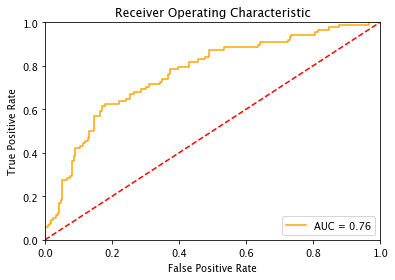

In [43]:
## Evaluate the weighted model

scores = score_model(probabilities, 0.5)
print_metrics(y_test, scores)  
plot_auc(y_test, probabilities) 

In [44]:
## Find a better threshold for im

def test_threshold(probs, labels, threshold):
    scores = score_model(probs, threshold)
    print('')
    print('For threshold = ' + str(threshold))
    print_metrics(labels, scores)

thresholds = [0.45, 0.40, 0.35, 0.3, 0.25]
for t in thresholds:
    test_threshold(probabilities, y_test, t)


For threshold = 0.45
                 Confusion matrix
                 Score positive    Score negative
Actual positive       157                55
Actual negative        29                59

Accuracy  0.72
 
           Positive      Negative
Num case      212            88
Precision    0.84          0.52
Recall       0.74          0.67
F1           0.79          0.58

For threshold = 0.4
                 Confusion matrix
                 Score positive    Score negative
Actual positive       148                64
Actual negative        27                61

Accuracy  0.70
 
           Positive      Negative
Num case      212            88
Precision    0.85          0.49
Recall       0.70          0.69
F1           0.76          0.57

For threshold = 0.35
                 Confusion matrix
                 Score positive    Score negative
Actual positive       137                75
Actual negative        23                65

Accuracy  0.67
 
           Positive      Negative
Num cas